In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy.stats import bernoulli, binom

# Part 1: Empirical Learning Rates for the Exponential Weights Algorithm

In [12]:
class EWAlg:
    def __init__(self, epsilon, k, h):
        self.weights = np.ones(k)
        self.payoffs = np.zeros(k)
        self.h = h
        self.k = k
        self.epsilon = epsilon
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights

    def getAction(self):
        j = np.random.choice(self.k, 1, p = self.probs)
        return j.item()
    
    def update(self, payoffs):
        for j in range(len(payoffs)):
            curPayoff = payoffs[j]
            self.payoffs[j] = self.payoffs[j] + curPayoff
            newWeight = (1+self.epsilon)**(self.payoffs[j]/self.h)
            self.weights[j] = newWeight
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        return

## Adversarial Fair Payoffs

In each round i:

Draw a payoff x ~ U[0,1] (i.e., from the uniform distribution on interval [0,1])

Assign this payoff to the action j* that has the smallest total payoff so far, i.e., j* = argminj Vji-1 where Vji = Σir=1 vji. 
(All other actions get 0 payoff in round i.)

In [13]:
h = 1 # fixed
# hyperparameters
k = 5
n = 100
epsilons = [0, 0.1, 0.1517, 0.2, 0.4, 0.6, 0.9, 1.5, 4, 100] # to be studied
monteCarloBound = 1000

avgPayoffs = []
avgRegrets = []
for epsilon in epsilons:
    sumPayoff = 0
    sumRegret = 0   
    for i in range(monteCarloBound):
        alg = EWAlg(epsilon, k, h)
        totalPayoffs = np.zeros(k)
        myPayoff = 0
        for i in range(n):
            # generate adversarial payoffs
            adversarialPayoffs = np.zeros(k)
            x = np.random.rand(1)
            least = np.argmin(totalPayoffs)
            adversarialPayoffs[least] = x
            totalPayoffs = totalPayoffs + adversarialPayoffs
            j = alg.getAction()
            myPayoff += adversarialPayoffs[j]
            alg.update(adversarialPayoffs)

        OPT = max(totalPayoffs)
        regret = (OPT - myPayoff).item() / n
        sumPayoff += myPayoff
        sumRegret += regret
    avgPayoffs.append(sumPayoff/n)
    avgRegrets.append(sumRegret/n)

print(epsilons)
print(avgPayoffs)
print(avgRegrets)

[0, 0.1, 0.1517, 0.2, 0.4, 0.6, 0.9, 1.5, 4, 100]
[100.73802472416455, 98.51605804961771, 97.34481268557174, 95.43618405792476, 91.41127605838209, 86.93026821349298, 84.51021414806837, 77.21676147608852, 62.11456462066515, 21.98877041421019]
[0.026755021060993874, 0.045508904892274986, 0.05748640615421914, 0.07515157154007655, 0.1179739122056812, 0.1631453867071179, 0.186690223275058, 0.25900553108504143, 0.41111261344010186, 0.812324700910269]


/var/folders/kb/z6625cjd6pq30cwdbky7yddr0000gn/T/ipykernel_40188/3490768314.py:5: RuntimeWarning: divide by zero encountered in log
  plt.bar(np.log(epsilons),avgPayoffs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_axes.py:2162: RuntimeWarning: invalid value encountered in double_scalars
  dx = [convert(x0 + ddx) - x for ddx in dx]


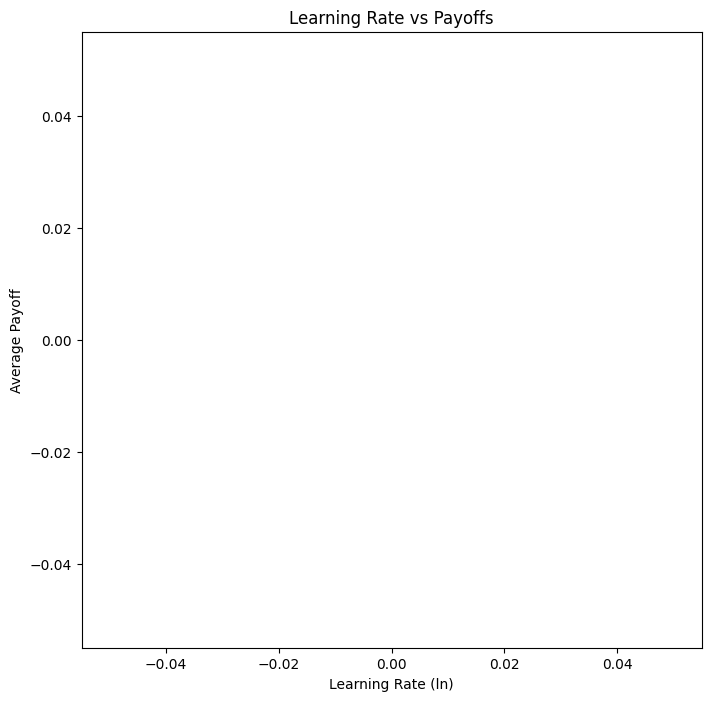

/var/folders/kb/z6625cjd6pq30cwdbky7yddr0000gn/T/ipykernel_40188/3490768314.py:14: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(epsilons),avgRegrets)


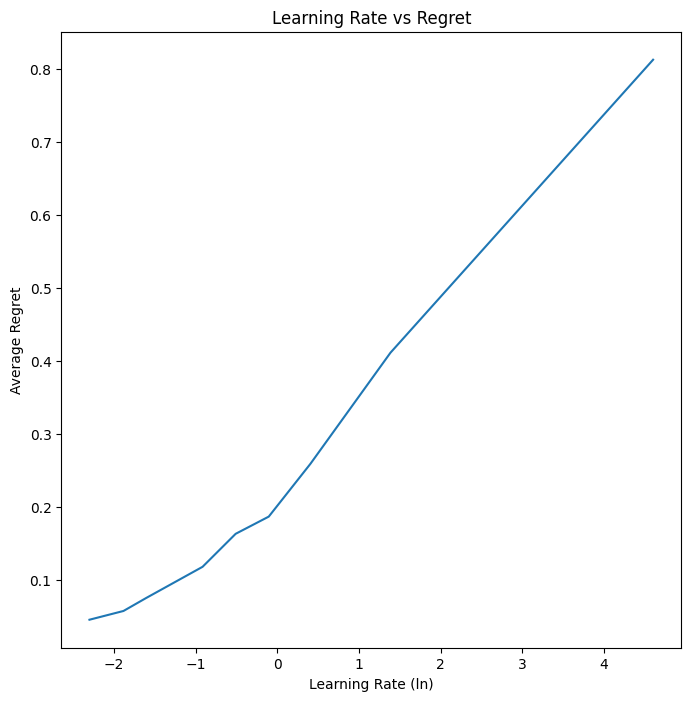

In [ ]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

plt.bar(np.log(epsilons),avgPayoffs)
plt.title('Learning Rate vs Payoffs')
plt.xlabel('Learning Rate (ln)')
plt.ylabel('Average Payoff')
plt.show()

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.plot(np.log(epsilons),avgRegrets)
plt.title('Learning Rate vs Regret')
plt.xlabel('Learning Rate (ln)')
plt.ylabel('Average Regret')
plt.show()

## Bernoulli Payoffs

In [16]:
h = 1 # fixed
# hyperparameters
k = 10
n = 100
epsilons = [0, 0.1, 0.1517, 0.2, 0.4, 0.6, 0.9, 1.5, 4, 100] # to be studied
monteCarloBound = 125

avgPayoffs = []
avgRegrets = []
for epsilon in epsilons:
    sumPayoff = 0
    sumRegret = 0   
    for i in range(monteCarloBound):
        payoffProbs = np.random.uniform(0, 0.5, k)
        bernouliPayoffs = [bernoulli(p) for p in payoffProbs]
        alg = EWAlg(epsilon, k, h)
        totalPayoffs = np.zeros(k)
        myPayoff = 0
        for i in range(n):
            # generate bernouli payoffs
            iPayoffs = np.array([b.rvs(1) for b in bernouliPayoffs]).flatten()
            totalPayoffs = totalPayoffs + iPayoffs
            j = alg.getAction()
            myPayoff += iPayoffs[j]
            alg.update(iPayoffs)

        OPT = max(totalPayoffs)
        regret = (OPT - myPayoff).item() / n
        sumPayoff += myPayoff
        sumRegret += regret
    avgPayoffs.append(sumPayoff/n)
    avgRegrets.append(sumRegret/n)

print(epsilons)
print(avgPayoffs)
print(avgRegrets)

[0, 0.1, 0.1517, 0.2, 0.4, 0.6, 0.9, 1.5, 4, 100]
[31.27, 41.93, 44.62, 46.28, 47.93, 51.15, 51.22, 51.81, 51.76, 52.96]
[0.2664, 0.17530000000000004, 0.15760000000000002, 0.13349999999999995, 0.10529999999999991, 0.07899999999999995, 0.07999999999999996, 0.06979999999999995, 0.06399999999999995, 0.06389999999999997]


/var/folders/kb/z6625cjd6pq30cwdbky7yddr0000gn/T/ipykernel_40188/3020364640.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(epsilons),avgPayoffs)


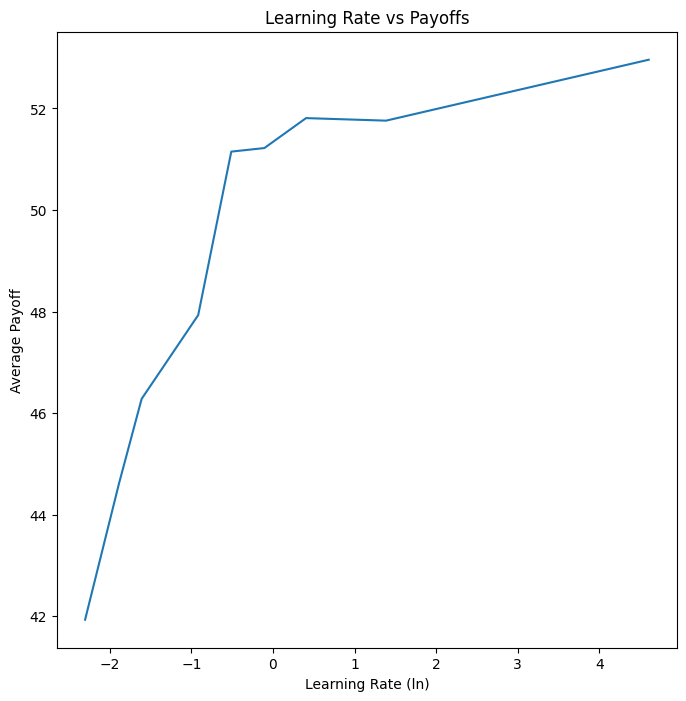

/var/folders/kb/z6625cjd6pq30cwdbky7yddr0000gn/T/ipykernel_40188/3020364640.py:14: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(epsilons),avgRegrets)


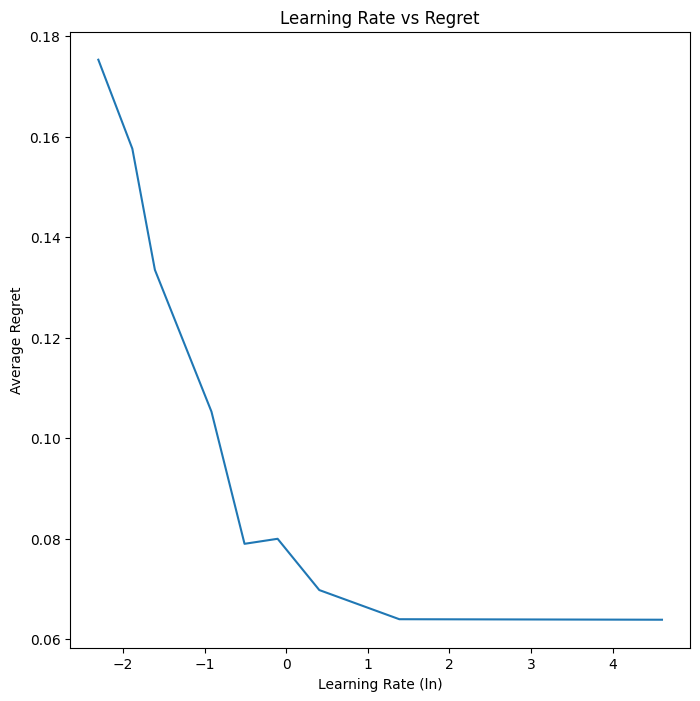

In [18]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

plt.plot(np.log(epsilons),avgPayoffs)
plt.title('Learning Rate vs Payoffs')
plt.xlabel('Learning Rate (ln)')
plt.ylabel('Average Payoff')
plt.show()

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.plot(np.log(epsilons),avgRegrets)
plt.title('Learning Rate vs Regret')
plt.xlabel('Learning Rate (ln)')
plt.ylabel('Average Regret')
plt.show()